# ABC Rejection

This example shows you how to perform ABC rejection on a time series (using a logisitic toy model).

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Define own RMSE error measure with noise added to simulated data

In [29]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

# Error measure with noise added to simulated data
class ErrorMeasure(object):
    """
    Abstract base class for objects that calculate some scalar measure of
    goodness-of-fit (for a model and a data set), such that a smaller value
    means a better fit.
    
    ErrorMeasures are callable objects: If ``e`` is an instance of an
    ``ErrorMeasure`` class you can calculate the error by calling ``e(p)``
    where ``p`` is a point in parameter space.
    """
    def __call__(self, x):
        raise NotImplementedError


    def n_parameters(self):
        """
        Returns the dimension of the parameter space this measure is defined
        over.
        """
        raise NotImplementedError


class ProblemErrorMeasure(ErrorMeasure):
    """
    Abstract base class for ErrorMeasures defined for
    :class:`single<pints.SingleOutputProblem>` or
    :class:`multi-output<pints.MultiOutputProblem>` problems.
    """
    def __init__(self, problem=None):
        super(ProblemErrorMeasure, self).__init__()
        self._problem = problem
        self._times = problem.times()
        self._values = problem.values()
        self._n_outputs = problem.n_outputs()
        self._n_parameters = problem.n_parameters()
        self._n_times = len(self._times)

    def n_parameters(self):
        """ See :meth:`ErrorMeasure.n_parameters()`. """
        return self._n_parameters


class noisy_RMSE(ProblemErrorMeasure):
    """
    Calculates a root mean squared error (RMSE) on a simulated dataset with noise:
    ``f = sqrt( sum( (x[i] - y[i])**2 / n) )``
    Arguments:
    
    ``problem``
        A :class:`pints.SingleOutputProblem`
    *Extends:* :class:`ProblemErrorMeasure`

    """
    def __init__(self, problem, real_noise):
        super(noisy_RMSE, self).__init__(problem)

        if not isinstance(problem, pints.SingleOutputProblem):
            raise ValueError(
                'This measure is only defined for single output problems.')
        self._ninv = 1.0 / len(self._values)
        
        self._real_noise = real_noise

    def __call__(self, x):
        deterministic_vals = self._problem.evaluate(x)
        sigma = np.random.uniform(0, 2*self._real_noise)
        simulated_vals = deterministic_vals + np.random.normal(0, sigma, len(deterministic_vals))
        
        return np.sqrt(self._ninv * np.sum(
            (simulated_vals - self._values)**2))



# PINTS implementation example

In [30]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.1, 50] 
times = np.linspace(0, 100, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 1
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)


In [31]:
# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.0, 0],
    [0.2, 100]       # Throws error when noise added!!! How should we add noise to the simulated data???
)

# Set the error measure to be used to compare simulated to observed data
error_measure = noisy_RMSE(problem, noise)

In [32]:
abc = pints.ABCController(error_measure, log_prior)     # method = pints.ABCRejection

abc.set_max_iterations(500000)
abc.set_threshold(1.2)
abc.set_n_target(500)
abc.set_n_draws(1)       # Much slower when run in parallel and plots look wider!!!
abc.set_parallel(False) 

In [33]:
# Run!
print('Running...')
posterior_estimate = abc.run()
print('Done!')

Running...
Halting: Maximum number of iterations (500000) reached.
Done!


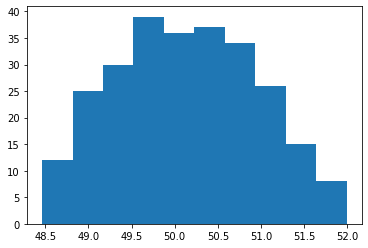

In [35]:
plt.hist(np.array(posterior_estimate)[:,1])
plt.show()

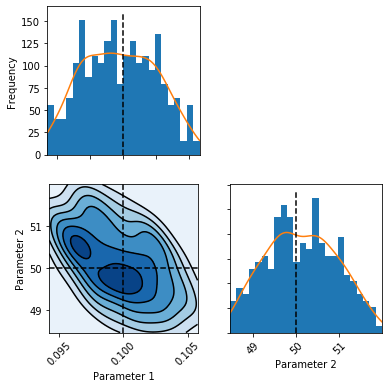

In [36]:
pints.plot.pairwise(np.array(posterior_estimate), kde = True, ref_parameters = real_parameters[:-1])
plt.show()